## Result Visualization ##

In this part of the project we will visualize concrete examples from action values given by our model and evaluate the capabilities and limitations of our model.

First we load the data from the previous step. If you have not already you should run the file 2_Training_Model.ipynb to retrieve the data and save it to a file.

In [813]:
import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer import Pitch
import numpy as np
from matplotlib.patches import Circle, Rectangle, RegularPolygon, Polygon
from matplotlib.patheffects import withStroke
from matplotlib import animation
import cmasher as cmr
import matplotlib.cm as cm
import matplotlib.colorbar as cbar
import seaborn as sns


df_model = pd.read_pickle("data/data_cleaned_trained.pkl")
player_minutes = pd.read_pickle("data/player_minutes.pkl")
df_labels = pd.read_pickle("data/data_cleaned.pkl")


FileNotFoundError: [Errno 2] No such file or directory: 'data/data_cleaned_trained.pkl'

Once the data is loading we can start with the visualization, we use this function to plot game states and action sequences.

In [ ]:
from matplotlib.patches import Arc

def plot_event_with_360_by_id(event_id, df, show_event_location=True):
    event_pos = df.reset_index(drop=True).query("id == @event_id").index

    if len(event_pos) == 0:
        print(f"[ERROR] Event ID '{event_id}' not found in DataFrame.")
        return

    event_row = df.iloc[event_pos[0]]

    p = Pitch(pitch_type='statsbomb', pitch_color="#a8bc95", line_color="white")
    fig, ax = p.draw(figsize=(12, 8))

    if isinstance(event_row['visible_area'], list) and len(event_row['visible_area']) >= 2:
        visible_area = np.array(event_row['visible_area']).reshape(-1, 2)
        p.polygon([visible_area], color='purple', alpha=0.25, ax=ax)

        if isinstance(event_row['freeze_frame'], list) and len(event_row['freeze_frame']) > 0:
            freeze_frame_df = pd.DataFrame(event_row['freeze_frame'])

            teammate_locs = freeze_frame_df[freeze_frame_df['teammate']]
            opponent_locs = freeze_frame_df[~freeze_frame_df['teammate']]

            p.scatter(teammate_locs['x'], teammate_locs['y'],
                      c='red', s=80, ec='k', ax=ax, label='Teammates')
            p.scatter(opponent_locs['x'], opponent_locs['y'],
                      c='blue', s=80, ec='k', ax=ax, label='Opponents')
    else:
        print("No visible_area available; only plotting event location.")

    if show_event_location and ('x' in event_row and 'y' in event_row):
        if pd.notna(event_row['x']) and pd.notna(event_row['y']):
            event_x, event_y = event_row['x'], event_row['y']
            p.scatter(event_x + 1, event_y, c='white', s=50, ax=ax, ec='k', label='Ball')

            label_text = event_row.get('type_name', 'Event')
            if pd.notna(event_row.get('sub_type_name')):
                label_text += f" ({event_row['sub_type_name']})"

            # Goal info
            goal_x = 120
            left_post_y = 43.66
            right_post_y = 36.34

            # Draw lines to goal posts
            ax.plot([event_x, goal_x], [event_y, left_post_y], color='black', linestyle='-', linewidth=1.5)
            ax.plot([event_x, goal_x], [event_y, right_post_y], color='black', linestyle='-', linewidth=1.5)

            # Annotations
            if 'distance_to_goal' in event_row and pd.notna(event_row['distance_to_goal']):
                dist_text = f"Distance: {event_row['distance_to_goal']:.1f} m"
                ax.text(event_x, event_y - 5, dist_text, color='black', fontsize=10, ha='left')

            if 'angle_to_goal' in event_row and pd.notna(event_row['angle_to_goal']):
                angle_deg = event_row['angle_to_goal']
                angle_text = f"Angle: {angle_deg:.1f}°"
                ax.text(event_x, event_y - 10, angle_text, color='black', fontsize=10, ha='left')


    ax.legend()
    plt.show()


In [ ]:
SCENARIO = "d9b92dbd-4fea-4f48-b2fb-d7222eab2dbd" # 289a2e06-0846-4e2e-bbbd-b25663eac17b Switzerland PP example

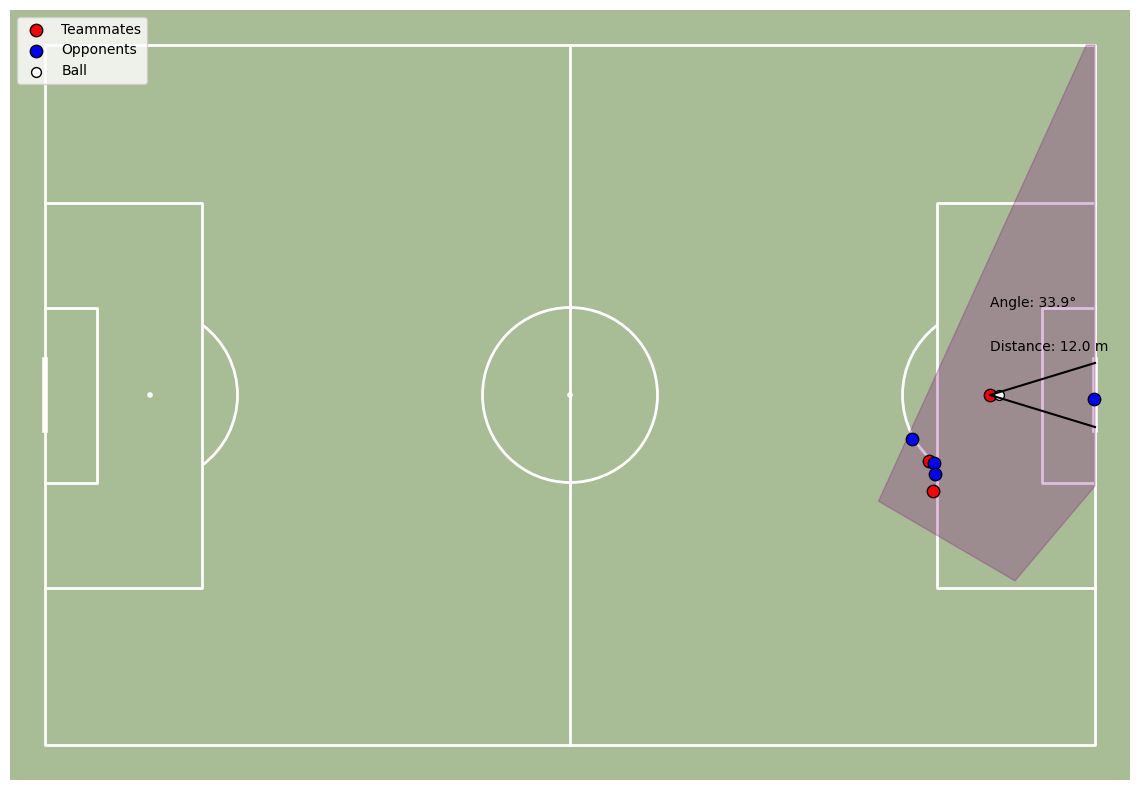

In [ ]:
plot_event_with_360_by_id(SCENARIO, df_model)

Next we visualise the five preceeding actions of a chosen action by its ID.

In [ ]:
LOW_VALUE_ACTIONS = ['ball recovery']


OFFENSIVE_ACTIONS = ['shot', 'pass', 'dribble', 'carry']
DEFENSIVE_ACTIONS = ['interception', 'tackle', 'block', 'clearance']

def fix_coordinates(sequence):
    sequence = sequence.copy()
    attacking_team = None

    for idx, row in sequence.iterrows():
        team = row.get('team_name')
        action = str(row.get('type_name', '')).lower()

        if attacking_team is None:
            attacking_team = team

        is_defending = team != attacking_team

        if is_defending:
            if pd.notna(row['x']):
                sequence.at[idx, 'x'] = 120 - row['x']
            if pd.notna(row['y']):
                sequence.at[idx, 'y'] = 80 - row['y']

        if is_defending and action in ['pass', 'carry', 'dribble', 'shot']:
            attacking_team = team

    return sequence

def get_action_chain(df, event_id, window=6):
    df = df.reset_index(drop=True)
    pos = df.query("id == @event_id").index

    if len(pos) == 0:
        raise ValueError(f"Event ID '{event_id}' not found.")
    pos = pos[0]

    chain = []
    picked_indices = set()
    i = pos

    while len(chain) < window and i >= 0:
        row = df.iloc[i]
        action = str(row.get("type_name", "")).lower()

        if i in picked_indices:
            i -= 1
            continue

        if action in LOW_VALUE_ACTIONS:
            for j in range(i - 1, -1, -1):
                prev_row = df.iloc[j]
                prev_action = str(prev_row.get("type_name", "")).lower()
                if prev_action not in LOW_VALUE_ACTIONS and j not in picked_indices:
                    chain.insert(0, prev_row)
                    picked_indices.add(j)
                    break
        else:
            chain.insert(0, row)
            picked_indices.add(i)

        i -= 1

    return pd.DataFrame(chain)

In [ ]:
def plot_action_chain_by_id(df, event_id):
    event_pos = df.reset_index(drop=True).query("id == @event_id").index

    if len(event_pos) == 0:
        print(f"[ERROR] Event ID '{event_id}' not found in DataFrame.")
        return

    pos = event_pos[0]
    start_pos = max(0, pos - 5)
    sequence = get_action_chain(df, event_id)
    sequence = fix_coordinates(sequence)

    if sequence.empty:
        print(f"[ERROR] No sequence found for event ID '{event_id}'")
        return

    fig, axs = plt.subplots(2, 1, figsize=(12, 10), gridspec_kw={'height_ratios': [1, 4]})
    table_ax, pitch_ax = axs
    table_ax.axis("off")

    col_labels = ['#', 'TIME', 'PLAYER', 'ACTION', r'$P_{scores}$', 'VALUE']
    cell_text = []

    for display_idx, (_, row) in enumerate(sequence.iterrows(), 1):
        time = f"{int(row.get('minute', 0))}m{int(row.get('second', 0))}s"
        player = row.get('player_name', 'Unknown')
        action = row.get('type_name', 'Action').lower()
        pscore = round(row.get('predicted_goal_prob', 0.0), 2)
        value = round(row.get('action_value', 0.0), 2)
        sign = "+" if value >= 0 else ""
        cell_text.append([display_idx, time, player, action, f"{pscore:.2f}", f"{sign}{value:.2f}"])

    table_ax.table(cellText=cell_text, colLabels=col_labels, cellLoc='center',
                   loc='upper center', colWidths=[0.05, 0.15, 0.2, 0.2, 0.15, 0.15])

    pitch = Pitch(pitch_type='statsbomb', pitch_color='#a8bc95', line_color='white')
    pitch.draw(ax=pitch_ax)


    for i in range(len(sequence)):
        row = sequence.iloc[i]
        x, y = row.get('x'), row.get('y')
        if pd.isna(x) or pd.isna(y):
            continue

        if i > 0:
            prev_row = sequence.iloc[i - 1]
            x0, y0 = prev_row.get('x'), prev_row.get('y')
            if pd.notna(x0) and pd.notna(y0):
                prev_action = str(prev_row.get('type_name', '')).lower()
                if any(word in prev_action for word in ['pass', 'shot']):
                    linestyle = 'solid'
                elif any(word in prev_action for word in ['carry', 'duel', 'dribble']):
                    linestyle = 'dashed'
                else:
                    linestyle = 'solid'

                pitch_ax.annotate(
                    '',
                    xy=(x, y),
                    xytext=(x0, y0),
                    arrowprops=dict(
                        arrowstyle="->",
                        color='black',
                        lw=2,
                        linestyle=linestyle,
                        alpha=0.6
                    )
                )

        action = str(row.get('type_name', '')).lower()
        value = round(row.get('action_value', 0.0), 2)

        if 'shot' in action:
            marker = Rectangle((x - 1, y - 1), 2, 2, color='blue', ec='k')
        elif 'dribble' in action or 'take on' in action:
            marker = RegularPolygon((x, y), numVertices=3, radius=2, orientation=np.pi / 2, color='blue', ec='k')
        else:
            marker = Circle((x, y), radius=2, color='lightblue', ec='k')

        pitch_ax.add_patch(marker)
        display_idx = i + 1
        y_offset = 4 - (display_idx % 3) * 2

        pitch_ax.text(
            x, y - y_offset,
            f"({display_idx}) {action}\n{value:+.2f}",
            fontsize=10,
            ha='center', va='top',
            color='white',
            weight='bold',
            path_effects=[withStroke(linewidth=2, foreground='black')]
        )

        

    plt.tight_layout()
    plt.show()

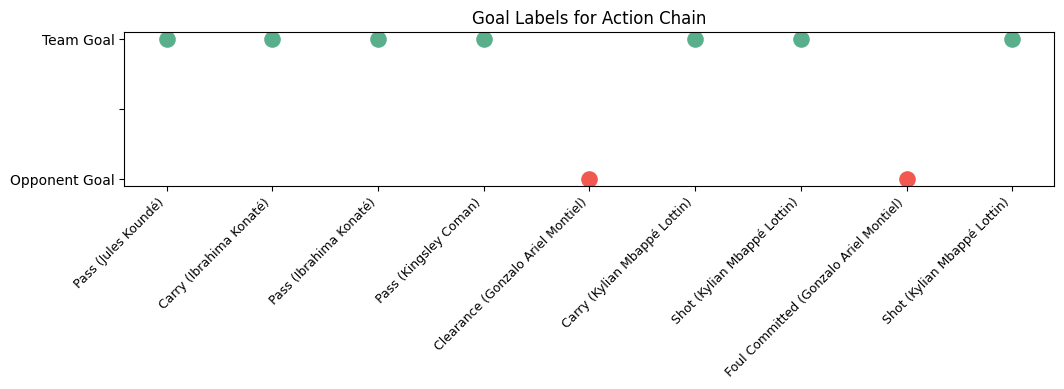

In [ ]:
def plot_goal_labels_for_action_chain(df_labels, event_id, window=10):
    chain = get_action_chain(df_labels, event_id, window=window)
    if chain.empty:
        print(f"No action chain found for event_id {event_id}")
        return

    actions = [f"{row['type_name']} ({row['player_name']})" for _, row in chain.iterrows()]
    team_goals = chain['label_team_goal'].values
    opp_goals = chain['label_opponent_goal'].values
    x = np.arange(len(actions))

    fig, ax = plt.subplots(figsize=(12, 2))
    # Team goal
    ax.scatter(x[team_goals == 1], [1]*np.sum(team_goals == 1), color='#59af8c', s=120, label='Team Goal')
    # Opponent goal
    ax.scatter(x[opp_goals == 1], [0]*np.sum(opp_goals == 1), color='#f05850', s=120, label='Opponent Goal')

    ax.set_yticks([0, 0.5, 1])
    ax.set_yticklabels(['Opponent Goal', '', 'Team Goal'])
    ax.set_xticks(x)
    ax.set_xticklabels(actions, rotation=45, ha='right', fontsize=9)
    ax.set_title('Goal Labels for Action Chain')
    plt.tight_layout()
    plt.show()
    
plot_goal_labels_for_action_chain(df_labels, event_id=SCENARIO, window=9)

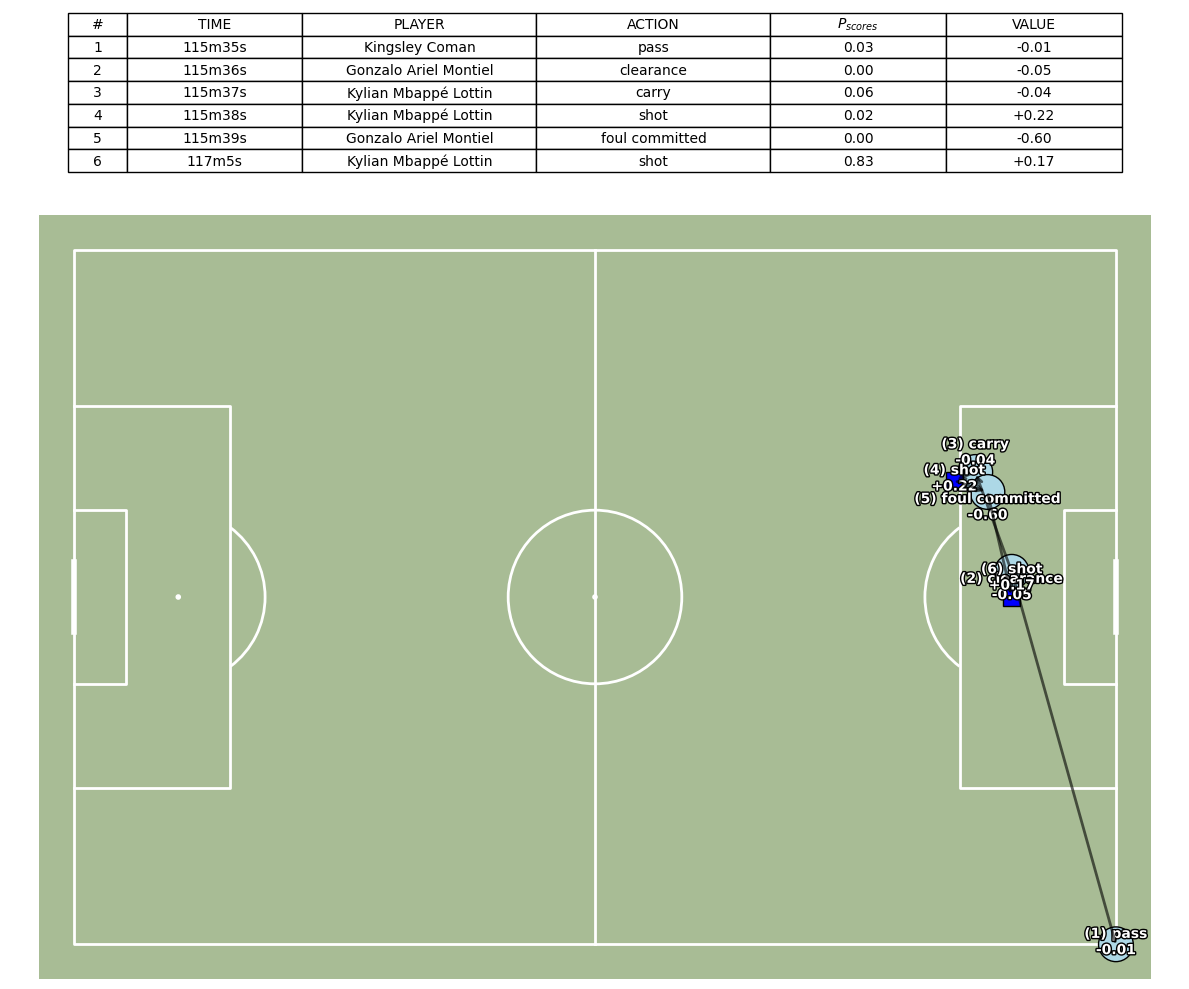

In [ ]:
plot_action_chain_by_id(df_model, SCENARIO)

In [ ]:
# 17949ad2-d653-49cb-95e4-2efe585438dc f7164861-b772-4dfb-96d7-37e3ec5bfefd = Japan Comeback 57c5911b-9d18-4c11-8975-c73e81ed0940 = Cameroon vs Brazil

To make this more dynamic, we can animate it and plot it with the changing goal / conceding probabilites. The purple area marks the area that was captured by the camera, when creating this data.

In [ ]:
def animate_action_chain(df, event_id, window=6, save_path=None):
    sequence = get_action_chain(df, event_id, window=window)
    sequence = fix_coordinates(sequence)

    attacking_team = sequence.iloc[0].get('team_name')
    for i, row in sequence.iterrows():
        curr_team = row.get('team_name')
        action = str(row.get('type_name', '')).lower()
        is_defending = curr_team != attacking_team

        # Mirror freeze_frame
        if isinstance(row.freeze_frame, list):
            ff_df = pd.DataFrame(row.freeze_frame)
            if is_defending:
                if 'x' in ff_df.columns:
                    ff_df['x'] = 120 - ff_df['x']
                if 'y' in ff_df.columns:
                    ff_df['y'] = 80 - ff_df['y']
            sequence.at[i, 'freeze_frame'] = ff_df.to_dict(orient='records')

        # Mirror visible_area (flat list of x, y)
        if isinstance(row.visible_area, list) and len(row.visible_area) >= 2:
            arr = np.array(row.visible_area)
            arr = arr.copy()
            if is_defending:
                arr[0::2] = 120 - arr[0::2]  # x values
                arr[1::2] = 80 - arr[1::2]   # y values
            sequence.at[i, 'visible_area'] = arr.reshape(-1, 2).tolist()

        # Now update attacking_team if possession changes
        if is_defending and action in ['pass', 'carry', 'dribble', 'shot']:
            attacking_team = curr_team

    # ...rest of your function unchanged...
    team_names = sequence['team_name'].unique()
    if len(team_names) >= 2:
        team1, team2 = team_names[0], team_names[1]
    elif len(team_names) == 1:
        team1 = team_names[0]
        match_id = sequence.iloc[0].get('match_id')
        if match_id and 'match_id' in df.columns and 'team_name' in df.columns:
            teams_in_match = df[df['match_id'] == match_id]['team_name'].unique()
            team2 = [t for t in teams_in_match if t != team1]
            team2 = team2[0] if team2 else "Opponent"
        else:
            team2 = "Opponent"
    else:
        team1, team2 = "Team", "Opponent"

    pitch = Pitch(pitch_type='statsbomb', pitch_color='#a8bc95', line_color='white')
    fig, (ax, ax_bar) = plt.subplots(1, 2, figsize=(20, 10), gridspec_kw={'width_ratios': [3, 1]})
    pitch.draw(ax=ax)

    teammate_markers = [ax.plot([], [], 'o', color='blue', markersize=10, markeredgecolor='black')[0] for _ in range(11)]
    opponent_markers = [ax.plot([], [], 'o', color='red', markersize=10, markeredgecolor='black')[0] for _ in range(11)]

    visible_area_poly = Polygon(np.zeros((4, 2)), closed=True, color='purple', alpha=0.3)
    ax.add_patch(visible_area_poly)

    annotations, arrows = [], []
    bars = ax_bar.bar(
        ['P(Goal)', 'P(Concede)'],
        [0, 0],
        color=["#59af8c", "#f05850"],
        width=0.2
    )
    ax_bar.set_xticks([0, 1])
    ax_bar.set_xticklabels(['P(Goal)', 'P(Concede)'])

    ax_bar.set_title('Predicted Goal Probability Over Time')
    ax_bar.set_ylim(0, 0.5)
    ax_bar.set_yticks(np.arange(0, 0.51, 0.1))
    ax_bar.set_ylabel('P(Goal)')

    from matplotlib.lines import Line2D
    legend_handles = [
        Line2D([0], [0], marker='o', color='w', label=team1, markerfacecolor='blue', markeredgecolor='black', markersize=10),
        Line2D([0], [0], marker='o', color='w', label=team2, markerfacecolor='red', markeredgecolor='black', markersize=10)
    ]
    ax.legend(handles=legend_handles, loc='upper right', fontsize=12, frameon=True)

    def update(frame):
        row = sequence.iloc[min(frame, len(sequence) - 1)]

        if hasattr(row, 'visible_area') and row.visible_area:
            try:
                visible_coords = np.array(row.visible_area).reshape(-1, 2)
                if visible_coords.shape[0] >= 3:
                    visible_area_poly.set_xy(visible_coords)
                else:
                    visible_area_poly.set_xy(np.zeros((4, 2)))
            except Exception:
                visible_area_poly.set_xy(np.zeros((4, 2)))

        # Clear old
        for ann in annotations:
            ann.remove()
        annotations.clear()

        for arr in arrows:
            arr.remove()
        arrows.clear()

        # Freeze frame markers (no fix_coordinates here!)
        if isinstance(row.freeze_frame, list):
            freeze_frame_df = pd.DataFrame(row.freeze_frame)
            teammates = freeze_frame_df[freeze_frame_df['teammate']]
            opponents = freeze_frame_df[~freeze_frame_df['teammate']]

            for i, marker in enumerate(teammate_markers):
                if i < len(teammates):
                    marker.set_data([teammates.iloc[i].x], [teammates.iloc[i].y])
                else:
                    marker.set_data([], [])

            for i, marker in enumerate(opponent_markers):
                if i < len(opponents):
                    marker.set_data([opponents.iloc[i].x], [opponents.iloc[i].y])
                else:
                    marker.set_data([], [])

        # Update bars
        bars[0].set_height(row.get('predicted_goal_prob', 0))
        bars[1].set_height(row.get('predicted_concede_prob', 0))
        bars[0].set_color("#59af8c")
        bars[1].set_color("#f05850")

        # Draw action arrows
        for i in range(1, frame + 1):
            prev_row = sequence.iloc[i - 1]
            curr_row = sequence.iloc[i]

            x0, y0 = prev_row.get('x'), prev_row.get('y')
            x1, y1 = curr_row.get('x'), curr_row.get('y')

            if pd.notna(x0) and pd.notna(y0) and pd.notna(x1) and pd.notna(y1):
                prev_action = str(prev_row.get('type_name', '')).lower()
                linestyle = 'solid' if any(k in prev_action for k in ['pass', 'shot']) else 'dashed'
                arrow = ax.annotate(
                    '', xy=(x1, y1), xytext=(x0, y0),
                    arrowprops=dict(
                        arrowstyle='->',
                        lw=2,
                        color='black',
                        linestyle=linestyle,
                        alpha=0.6
                    )
                )
                arrows.append(arrow)

        # Draw annotations
        for i in range(frame + 1):
            row = sequence.iloc[i]
            x, y = row.get('x'), row.get('y')
            action = str(row.get('type_name', '')).lower()
            value = round(row.get('action_value', 0.0), 2)
            display_idx = i + 1
            y_offset = 4 - (display_idx % 3) * 2
            ann = ax.text(
                x, y - y_offset,
                f"{value:+.2f} {action} ({display_idx})",
                fontsize=10,
                ha='center', va='top',
                color='white',
                weight='bold',
                path_effects=[withStroke(linewidth=2, foreground='black')]
            )
            annotations.append(ann)

        return (
            teammate_markers +
            opponent_markers +
            [visible_area_poly] +
            list(bars) +
            annotations +
            arrows
        )

    anim = animation.FuncAnimation(fig, update, frames=len(sequence), interval=200, blit=False)

    if save_path:
        anim.save(save_path, dpi=150, fps=1, extra_args=['-vcodec', 'libx264'])

    plt.show()

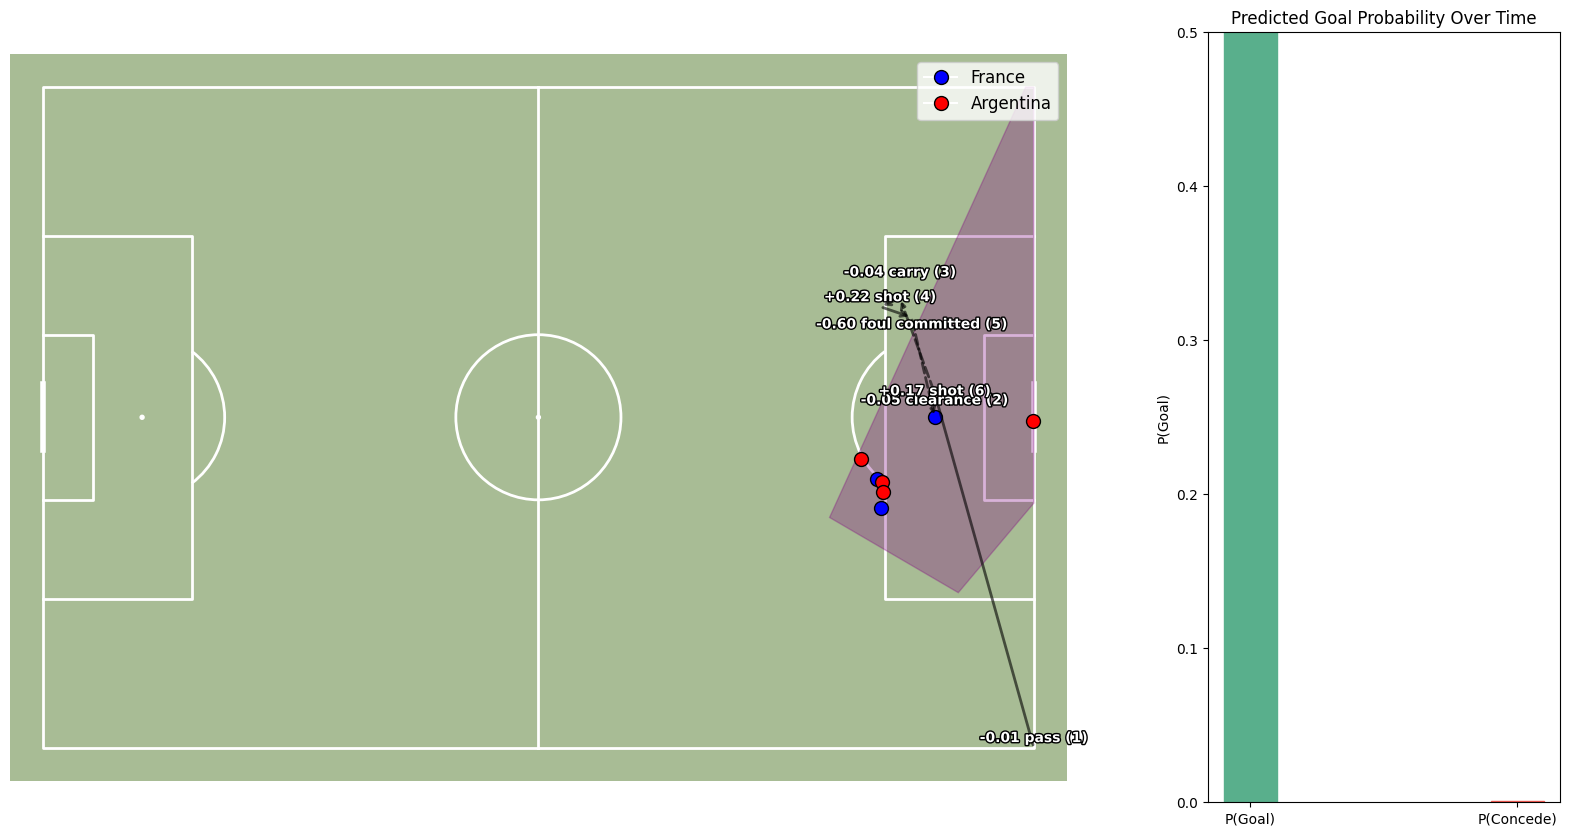

In [ ]:
animate_action_chain(df_model, SCENARIO, save_path='action_chain_animation.mp4')

Next we visualise the heat map per team / per player, to see how teams / players have managed to create the most value. Or in other words, where the teams / players strength lies.

In [ ]:
def plot_team_goal_prob_heatmap(team_id, player_id=None, df_path="data/data_cleaned_trained.pkl"):
    # Load data
    df = pd.read_pickle(df_path)

    # Filter by team (and player if specified)
    if player_id is not None:
        df_filtered = df[
            (df['team_id'] == team_id) &
            (df['player_id'] == player_id) &
            (df['predicted_goal_prob'].notna())
        ]
    else:
        df_filtered = df[
            (df['team_id'] == team_id) &
            (df['predicted_goal_prob'].notna())
        ]

    # Filter out penalty shots
    if 'sub_type_name' in df_filtered.columns:
        df_filtered = df_filtered[~df_filtered['sub_type_name'].str.lower().eq('penalty')]

    if df_filtered.empty:
        print(f"[INFO] No events with predicted_goal_prob for team_id {team_id}" +
              (f" and player_id {player_id}" if player_id else ""))
        return

    team_name = df_filtered["team_name"].iloc[0]
    title = f"Heatmap of Predicted Goal Probability for {team_name}"
    if player_id:
        player_name = df_filtered["player_name"].iloc[0]
        title += f" - {player_name}"

    # Draw pitch
    pitch = Pitch(
        pitch_type='statsbomb',
        stripe=False,
        line_zorder=2
    )
    fig, ax = pitch.draw(figsize=(10, 6))
    ax.set_title(title, fontsize=14)

    # Heatmap config
    cmap = cmr.arctic_r
    kde = pitch.kdeplot(
        df_filtered['x'],
        df_filtered['y'],
        ax=ax,
        fill=True,
        cmap=cmap,
        levels=100,
        weights=df_filtered['predicted_goal_prob'],
        thresh=0.01,
        alpha=0.8,
        zorder=1
    )

    # Add colorbar
    sm = cm.ScalarMappable(cmap=cmap)
    sm.set_array(df_filtered['predicted_goal_prob'])
    cbar_obj = fig.colorbar(sm, ax=ax, orientation='horizontal', pad=0.05, fraction=0.04)
    cbar_obj.set_label('Predicted Goal Probability', fontsize=12)
    cbar_obj.ax.tick_params(labelsize=10)

    plt.show()



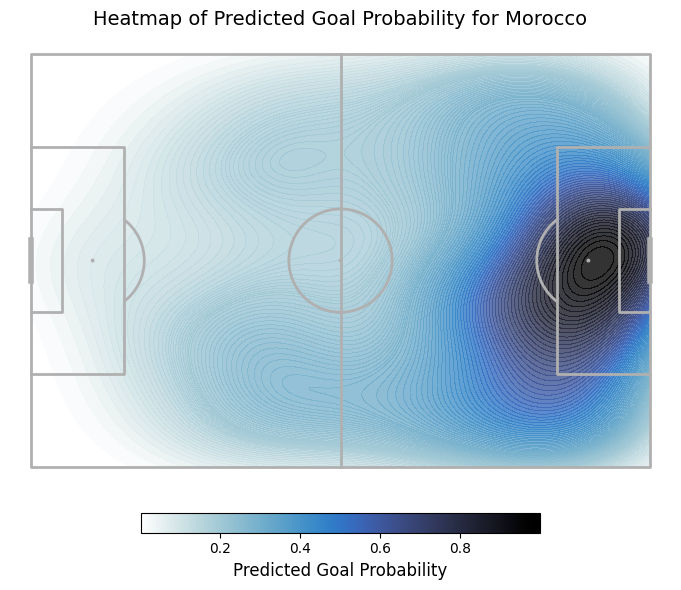

In [ ]:
plot_team_goal_prob_heatmap(team_id=788) # 788 for Morocco 5245 for Hakimi

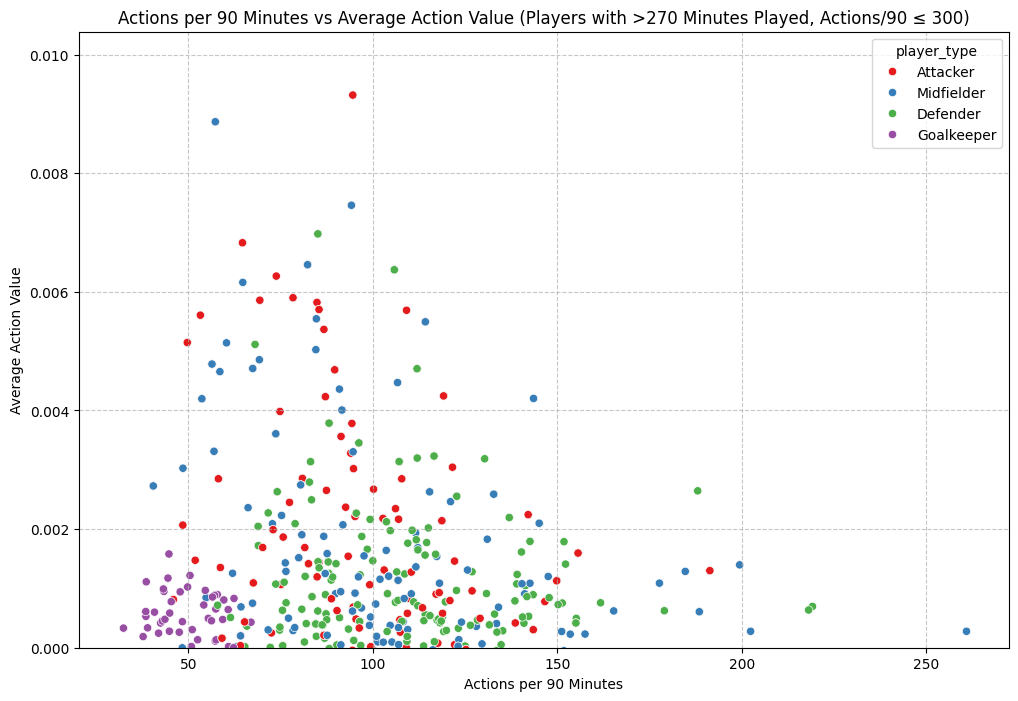

In [ ]:
# Define player type mapping
def get_player_type(position):
    if "Forward" in position or "Wing" in position:
        return "Attacker"
    elif "Back" in position or "Goalkeeper" in position:
        return "Defender" if "Goalkeeper" not in position else "Goalkeeper"
    elif "Midfield" in position:
        return "Midfielder"
    else:
        return "Unknown"

# Map player type
df_model['player_type'] = df_model['position_name'].apply(get_player_type)

# Calculate actions per 90 minutes
player_actions = df_model.groupby('player_id').size().reset_index(name='total_actions')
player_data = player_actions.merge(player_minutes, on='player_id')

# Filter players with more than 270 minutes played
player_data = player_data[player_data['minutes_played'] > 270]

player_data['actions_per_90'] = (player_data['total_actions'] / player_data['minutes_played']) * 90

# Remove players with actions per 90 > 300
player_data = player_data[player_data['actions_per_90'] <= 300]

# Calculate average action value for each player
player_values = df_model.groupby('player_id')['action_value'].mean().reset_index()
player_data = player_data.merge(player_values, on='player_id')

# Merge player type
player_data = player_data.merge(df_model[['player_id', 'player_type']].drop_duplicates(), on='player_id')

# Plotting
plt.figure(figsize=(12, 8))
sns.scatterplot(data=player_data, x='actions_per_90', y='action_value', hue='player_type', palette='Set1', alpha=1, edgecolor='w')

# Labels and title
plt.title('Actions per 90 Minutes vs Average Action Value (Players with >270 Minutes Played, Actions/90 ≤ 300)')
plt.xlabel('Actions per 90 Minutes')
plt.ylabel('Average Action Value')
plt.ylim(0)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()
